In [1]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install scikit-learn
# !pip install tensorflow
# !pip install kmodes

In [1]:
import re
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from kmodes.kprototypes import KPrototypes

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.models import load_model


%matplotlib inline

In [45]:
hotel_booking = pd.read_csv('DATA/hotel_booking.csv')
hotel_booking.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,is_h1
0,0,342,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
1,0,737,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
2,0,7,2015,July,27,1,0,1,1,0.0,...,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
3,0,13,2015,July,27,1,0,1,1,0.0,...,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
4,0,14,2015,July,27,1,0,2,2,0.0,...,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,1


In [46]:
# Checking Missing Data
hotel_booking.isna().sum()

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                           0
Children                         4
Babies                           0
Meal                             0
Country                        488
MarketSegment                    0
DistributionChannel              0
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                      0
Agent                            0
Company                          0
DaysInWaitingList                0
CustomerType                     0
ADR                              0
RequiredCarParkingSpaces         0
TotalOfSpecialReques

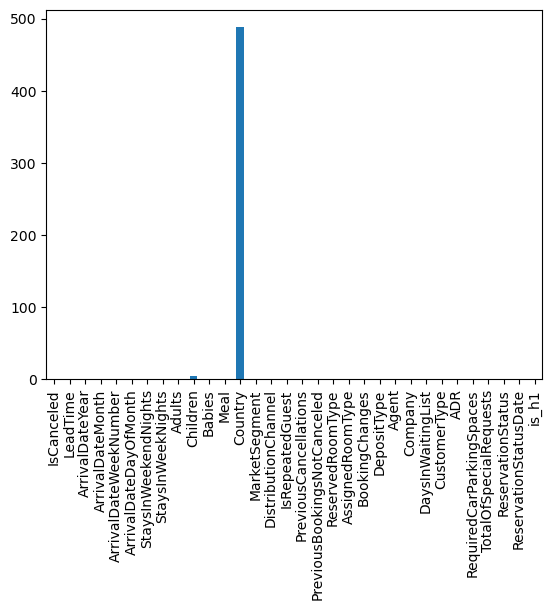

In [47]:
hotel_booking.isna().sum().plot(kind='bar');

## Data Preprocessing

In [48]:
# Creating a function to reformat the feature names:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [49]:
# Reformating the feature names:
hotel_booking.columns = hotel_booking.columns.map(camel_to_snake)

In [50]:
# Removing spaces:
features = ['meal', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company']
for feature in features:
    hotel_booking[feature] = hotel_booking[feature].str.strip()

#### Fill missing company and agent values

* missing `company` values says that booking did not came via any company
* missing `agent` values says that booking did not came from a agent

----

Therefore fill missing `company` and `agent` values as follows:
* missing `company` values as **No Company**
* missing `agent` values as **No Agent**

In [51]:
hotel_booking['agent'].replace(to_replace='NULL', value='No Agent', inplace=True)
hotel_booking['company'].replace(to_replace='NULL', value='No Company', inplace=True)

hotel_booking.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_h1
0,0,342,2015,July,27,1,0,0,2,0.0,...,No Agent,No Company,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
1,0,737,2015,July,27,1,0,0,2,0.0,...,No Agent,No Company,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
2,0,7,2015,July,27,1,0,1,1,0.0,...,No Agent,No Company,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
3,0,13,2015,July,27,1,0,1,1,0.0,...,304,No Company,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
4,0,14,2015,July,27,1,0,2,2,0.0,...,240,No Company,0,Transient,98.0,0,1,Check-Out,2015-07-03,1


In [52]:
hotel_booking['country'].fillna("unknown", inplace=True)

#### Drop missing children values

In [53]:
hotel_booking.dropna(subset=['children'], inplace=True)

In [54]:
hotel_booking.isna().sum()

is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

In [55]:
# check data type of each column
hotel_booking.dtypes

is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                              object
company                           

#### Fix data types of `children` and `reservation_satatus_date`

* There were 2 mismatched data types can be found in dataset.
* `children` column data type should be fixed as integer
* `reservation_status_date` column data type should be fixed as datetime

In [56]:
hotel_booking['children'] = hotel_booking['children'].astype(int)
hotel_booking['reservation_status_date'] = pd.to_datetime(hotel_booking['reservation_status_date'])

In [57]:
hotel_booking.dtypes

is_canceled                                int64
lead_time                                  int64
arrival_date_year                          int64
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                   int32
babies                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type                        object
booking_changes     

#### Check for the duplications

* We does not remove duplications since there can be more than one bookings with the same features on same day

In [58]:
hotel_booking.duplicated().any()

True

In [59]:
hotel_booking[hotel_booking.duplicated(keep='first')]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_h1
5,0,14,2015,July,27,1,0,2,2,0,...,240,No Company,0,Transient,98.00,0,1,Check-Out,2015-07-03,1
22,0,72,2015,July,27,1,2,4,2,0,...,250,No Company,0,Transient,84.67,0,1,Check-Out,2015-07-07,1
43,0,70,2015,July,27,2,2,3,2,0,...,250,No Company,0,Transient,137.00,0,1,Check-Out,2015-07-07,1
138,1,5,2015,July,28,5,1,0,2,0,...,240,No Company,0,Transient,97.00,0,0,Canceled,2015-07-01,1
200,0,0,2015,July,28,7,0,1,1,0,...,240,No Company,0,Transient,109.80,0,3,Check-Out,2015-07-08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119349,0,186,2017,August,35,31,0,3,2,0,...,9,No Company,0,Transient,126.00,0,2,Check-Out,2017-09-03,0
119352,0,63,2017,August,35,31,0,3,3,0,...,9,No Company,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,0
119353,0,63,2017,August,35,31,0,3,3,0,...,9,No Company,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,0
119354,0,63,2017,August,35,31,0,3,3,0,...,9,No Company,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,0


## Feature Engineering

**Creating new feature called** `arrival_date_full` **using** `arrival_date_year`**,** `arrival_date_month` **and** `arrival_date_day_of_month`

In [60]:
hotel_booking['arrival_date_full'] = hotel_booking['arrival_date_year'].astype(str) + "-" + hotel_booking['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + hotel_booking['arrival_date_day_of_month'].astype(str)

hotel_booking['arrival_date_full'] = pd.to_datetime(hotel_booking['arrival_date_full'], format="%Y-%m-%d")

In [61]:
hotel_booking.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_h1,arrival_date_full
0,0,342,2015,July,27,1,0,0,2,0,...,No Company,0,Transient,0.0,0,0,Check-Out,2015-07-01,1,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Company,0,Transient,0.0,0,0,Check-Out,2015-07-01,1,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Company,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,2015-07-01
3,0,13,2015,July,27,1,0,1,1,0,...,No Company,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,2015-07-01
4,0,14,2015,July,27,1,0,2,2,0,...,No Company,0,Transient,98.0,0,1,Check-Out,2015-07-03,1,2015-07-01


**Creating a new feature called** `status_minus_arrival_date` **representing length of stay or how many days before arrival did the customer cancel**

In [62]:
hotel_booking['status_minus_arrival_date'] = np.abs(hotel_booking['arrival_date_full'] - hotel_booking['reservation_status_date']).astype(str)

In [63]:
def format_lenght(date):
    return date[0]

In [64]:
hotel_booking['status_minus_arrival_date'] = hotel_booking['status_minus_arrival_date'].map(format_lenght).astype(int)

In [65]:
hotel_booking.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_h1,arrival_date_full,status_minus_arrival_date
0,0,342,2015,July,27,1,0,0,2,0,...,0,Transient,0.0,0,0,Check-Out,2015-07-01,1,2015-07-01,0
1,0,737,2015,July,27,1,0,0,2,0,...,0,Transient,0.0,0,0,Check-Out,2015-07-01,1,2015-07-01,0
2,0,7,2015,July,27,1,0,1,1,0,...,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,2015-07-01,1
3,0,13,2015,July,27,1,0,1,1,0,...,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,2015-07-01,1
4,0,14,2015,July,27,1,0,2,2,0,...,0,Transient,98.0,0,1,Check-Out,2015-07-03,1,2015-07-01,2


## Exploratory Data Analysis


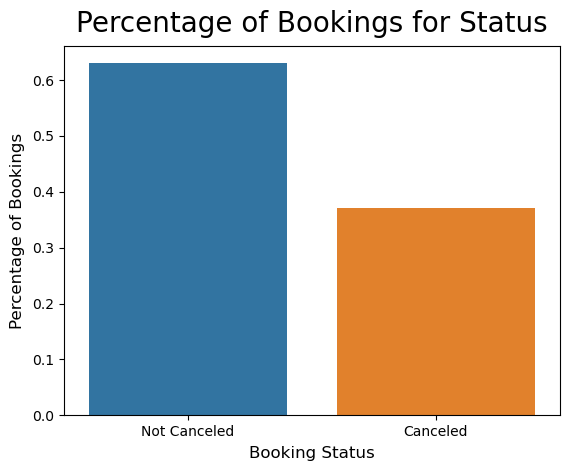

In [66]:
# Canceled Vs Not Canceled

plt.title("Percentage of Bookings for Status", fontsize = 20, pad = 10)
sns.barplot(x=hotel_booking['is_canceled'].unique(), y=hotel_booking['is_canceled'].value_counts(normalize=True))
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

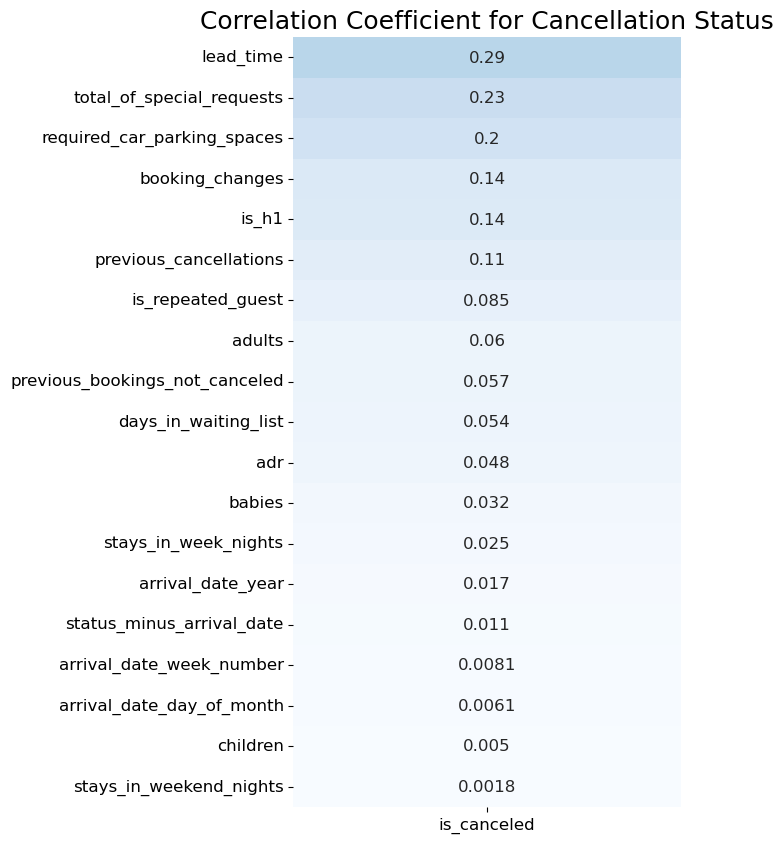

In [67]:
# Correlation between is_canceled and other features

fig = plt.figure(figsize=(5,10))
ax = sns.heatmap(hotel_booking.corr()[['is_canceled']].abs().sort_values('is_canceled', ascending=False), annot = True, annot_kws = {"size":12}, cmap='Blues', cbar=False)
ax.set_title('Correlation Coefficient for Cancellation Status', fontsize=18)
ax.tick_params(axis = "both", labelsize = 12)
y_min, y_max = ax.get_ylim()
ax.set_ylim(top=y_max+1);

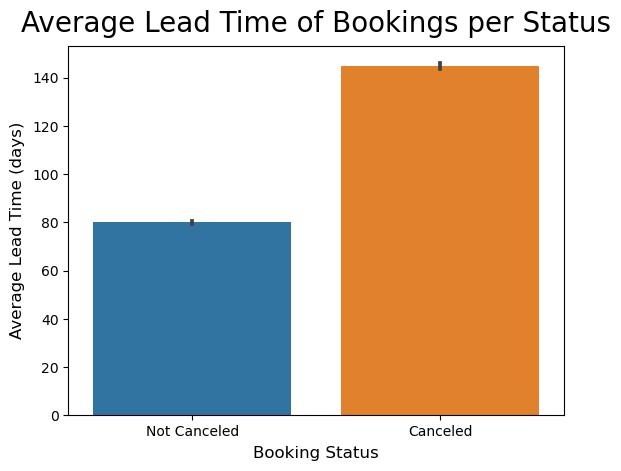

In [68]:
# Canceled Vs Not Canceled By average lead time

plt.title("Average Lead Time of Bookings per Status", fontsize = 20, pad = 10)
sns.barplot(x=hotel_booking['is_canceled'], y=hotel_booking['lead_time'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Lead Time (days)", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

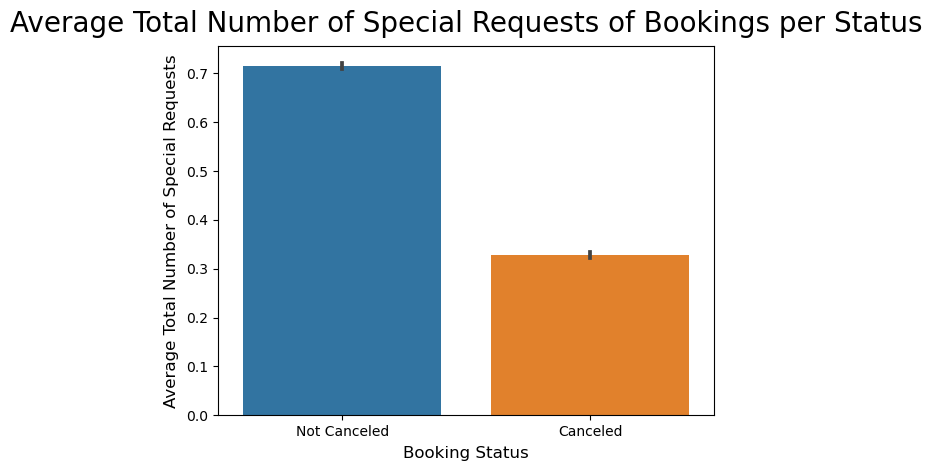

In [69]:
# Canceled Vs Not Canceled By average total number of special requests

plt.title("Average Total Number of Special Requests of Bookings per Status", fontsize = 20, pad = 10)
sns.barplot(x=hotel_booking['is_canceled'], y=hotel_booking['total_of_special_requests'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Total Number of Special Requests", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

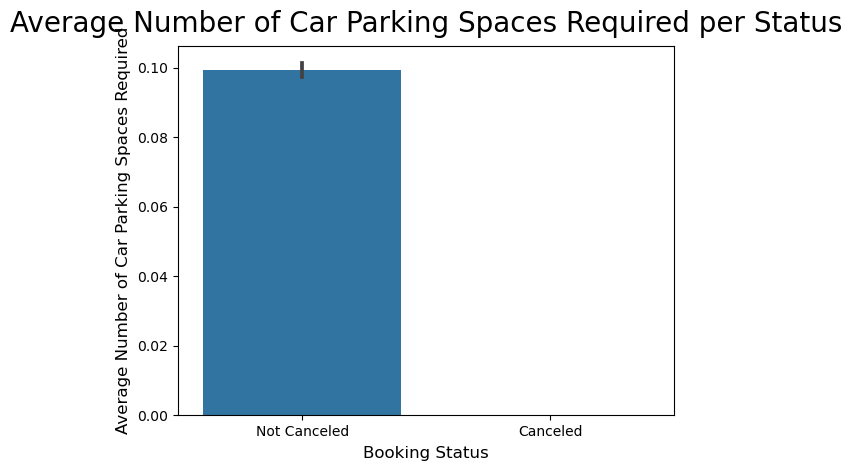

In [70]:
# Canceled Vs Not Canceled By average number of car parking spaces required

plt.title("Average Number of Car Parking Spaces Required per Status", fontsize = 20, pad = 10)
sns.barplot(x=hotel_booking['is_canceled'], y=hotel_booking['required_car_parking_spaces'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Number of Car Parking Spaces Required", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

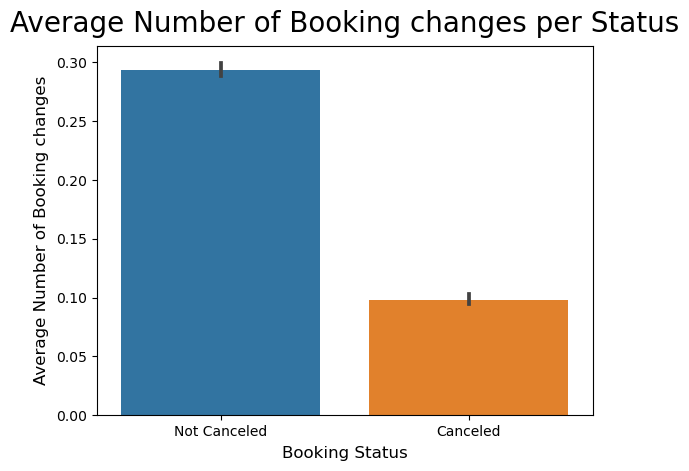

In [71]:
# Canceled Vs Not Canceled By average number of booking changes

plt.title("Average Number of Booking changes per Status", fontsize = 20, pad = 10)
sns.barplot(x=hotel_booking['is_canceled'], y=hotel_booking['booking_changes'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Number of Booking changes", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

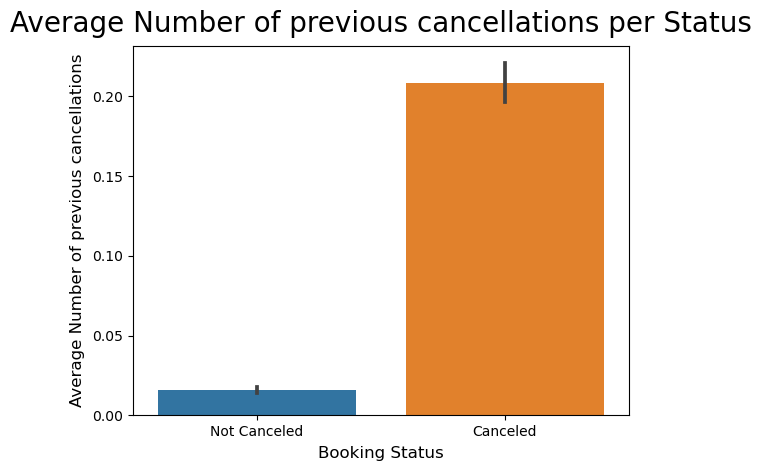

In [72]:
# Canceled Vs Not Canceled By average number of previous cancellations

plt.title("Average Number of previous cancellations per Status", fontsize = 20, pad = 10)
sns.barplot(x=hotel_booking['is_canceled'], y=hotel_booking['previous_cancellations'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Number of previous cancellations", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

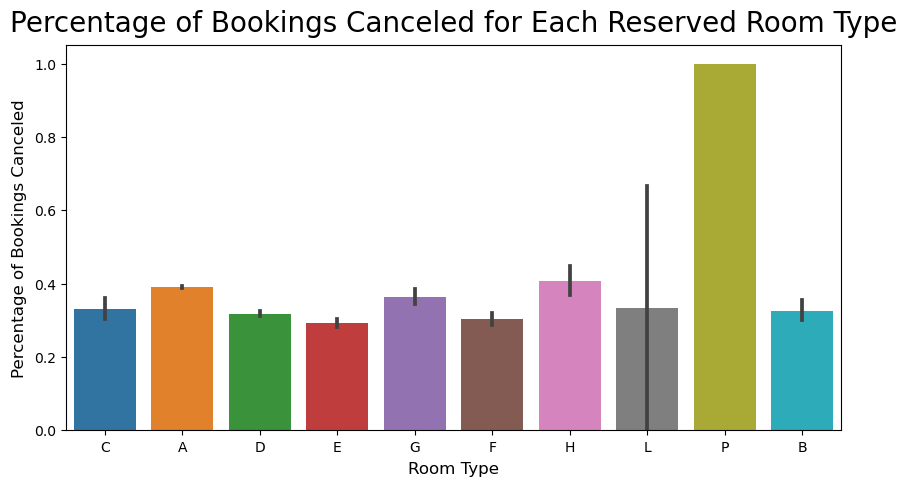

In [73]:
# Percentage of booking cancelled for room types

plt.figure(figsize=(10,5))
plt.title("Percentage of Bookings Canceled for Each Reserved Room Type", fontsize = 20, pad = 10)
sns.barplot(x=hotel_booking['reserved_room_type'], y=hotel_booking['is_canceled'])
plt.xlabel("Room Type", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12, labelpad = 5);

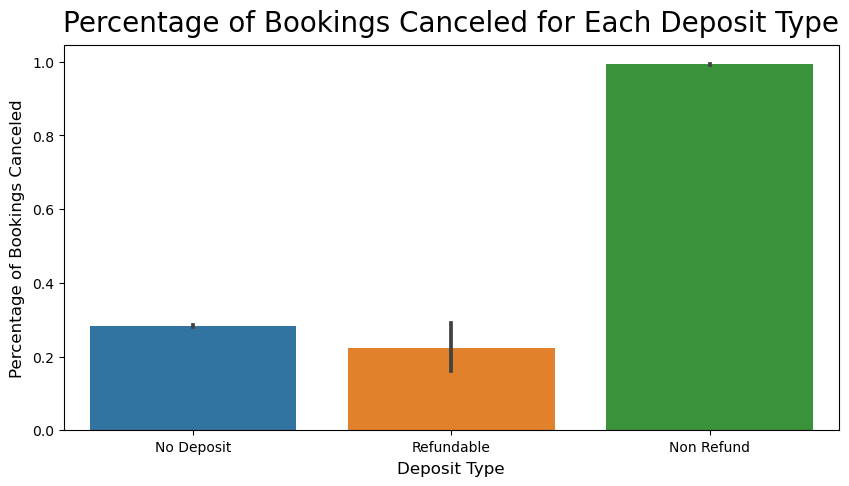

In [74]:
# Percentage of booking cancelled for deposit types

plt.figure(figsize=(10,5))
plt.title("Percentage of Bookings Canceled for Each Deposit Type", fontsize = 20, pad = 10)
sns.barplot(x=hotel_booking['deposit_type'], y=hotel_booking['is_canceled'])
plt.xlabel("Deposit Type", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12, labelpad = 5);

## Clustering

**Create the clusters to customer segmentation and improve the features of the dataset**

In [75]:
X = hotel_booking.drop(columns=['is_canceled', 'reservation_status', 'agent', 'company', 'country', 'reservation_status_date', 'arrival_date_full'])

In [76]:
X.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_h1,status_minus_arrival_date
0,342,2015,July,27,1,0,0,2,0,0,...,C,3,No Deposit,0,Transient,0.0,0,0,1,0
1,737,2015,July,27,1,0,0,2,0,0,...,C,4,No Deposit,0,Transient,0.0,0,0,1,0
2,7,2015,July,27,1,0,1,1,0,0,...,C,0,No Deposit,0,Transient,75.0,0,0,1,1
3,13,2015,July,27,1,0,1,1,0,0,...,A,0,No Deposit,0,Transient,75.0,0,0,1,1
4,14,2015,July,27,1,0,2,2,0,0,...,A,0,No Deposit,0,Transient,98.0,0,1,1,2


#### K-Prototypes Clusterning

* Since our dataset have both numerical and categorical features, K-Prototype clustering is the most appropriate model to create clusters

In [77]:
# Creating a loop to try our different number of clusters:
# kproto_costs = []
# for n in range(2, 8):
#     #do the clustering
#     kproto = KPrototypes(n_clusters=n, init='Huang', verbose=2, n_jobs=3, random_state=42, n_jobs=3)
#     clusters = kproto.fit_predict(X, categorical=[2, 10, 11, 12, 13, 16, 17, 19, 21, 25])
#     print(f'cost: {kproto.cost_}')
#     print(f'iter: {kproto.n_iter_}')
#
#     # get cost
#     cost = kproto.cost_
#
#     #gather them
#     kproto_costs.append((n, cost))

In [78]:
# costs_df = pd.DataFrame(kproto_costs, columns=['n', 'cost'])
# costs_df

In [79]:
# plt.figure(figsize=(10,5))
# plt.plot(costs_df['n'], costs_df['cost'])
# plt.xticks([2,3,4,5,6,7])
# plt.xlabel('Number of Clusters', fontsize=12)
# plt.ylabel('Cost', size=12)
# plt.title('Cost per Number of K-Prototype Cluster', size=20);

In [80]:
# Creating the 4 customer clusters:
# kproto = KPrototypes(n_clusters=4, init='Huang', verbose=0, random_state=42, n_jobs=3)
# clusters = kproto.fit_predict(X, categorical=[2, 10, 11, 12, 13, 16, 17, 19, 21, 25])
# print(f'cost: {kproto.cost_}')

In [81]:
# pickle.dump(kproto, open('Models/kproto.pkl', 'wb'))

In [82]:
kproto_loded = pickle.load(open('Models/kproto.pkl', 'rb'))

In [83]:
clusters = kproto_loded.fit_predict(X, categorical=[2, 10, 11, 12, 13, 16, 17, 19, 21, 25])
print(f'cost: {kproto_loded.cost_}')

cost: 436604819.63317287


In [84]:
# Creating a "clusters" feature in our dataset:
hotel_booking['clusters'] = clusters

In [85]:
# Renaming the clusters:
hotel_booking['clusters'] = hotel_booking['clusters'].map({0:'Type 1', 1:'Type 2', 2:'Type 3', 3:'Type 4'})

In [86]:
hotel_booking.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_h1,arrival_date_full,status_minus_arrival_date,clusters
0,0,342,2015,July,27,1,0,0,2,0,...,Transient,0.0,0,0,Check-Out,2015-07-01,1,2015-07-01,0,Type 1
1,0,737,2015,July,27,1,0,0,2,0,...,Transient,0.0,0,0,Check-Out,2015-07-01,1,2015-07-01,0,Type 1
2,0,7,2015,July,27,1,0,1,1,0,...,Transient,75.0,0,0,Check-Out,2015-07-02,1,2015-07-01,1,Type 3
3,0,13,2015,July,27,1,0,1,1,0,...,Transient,75.0,0,0,Check-Out,2015-07-02,1,2015-07-01,1,Type 3
4,0,14,2015,July,27,1,0,2,2,0,...,Transient,98.0,0,1,Check-Out,2015-07-03,1,2015-07-01,2,Type 3


In [87]:
# Save the dataframe to csv for the future usages
# hotel_booking.to_csv('DATA/hotel_booking_with_cluster.csv', index=False)

In [3]:
hotel_booking = pd.read_csv('DATA/hotel_booking_with_cluster.csv')

In [4]:
hotel_booking.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_h1,arrival_date_full,status_minus_arrival_date,clusters
0,0,342,2015,July,27,1,0,0,2,0,...,Transient,0.0,0,0,Check-Out,2015-07-01,1,2015-07-01,0,Type 1
1,0,737,2015,July,27,1,0,0,2,0,...,Transient,0.0,0,0,Check-Out,2015-07-01,1,2015-07-01,0,Type 1
2,0,7,2015,July,27,1,0,1,1,0,...,Transient,75.0,0,0,Check-Out,2015-07-02,1,2015-07-01,1,Type 3
3,0,13,2015,July,27,1,0,1,1,0,...,Transient,75.0,0,0,Check-Out,2015-07-02,1,2015-07-01,1,Type 3
4,0,14,2015,July,27,1,0,2,2,0,...,Transient,98.0,0,1,Check-Out,2015-07-03,1,2015-07-01,2,Type 3


In [5]:
cluster_analysis_df = hotel_booking.groupby(hotel_booking['clusters']).describe(include='all')
cluster_analysis_df

is_canceled                                                          \
               count unique top freq      mean       std  min  25%  50%  75%   
clusters                                                                       
Type 1       14390.0    NaN NaN  NaN  0.644128  0.478793  0.0  0.0  1.0  1.0   
Type 2       32053.0    NaN NaN  NaN  0.451377  0.497638  0.0  0.0  0.0  1.0   
Type 3       49625.0    NaN NaN  NaN  0.249390  0.432665  0.0  0.0  0.0  0.0   
Type 4       23318.0    NaN NaN  NaN  0.347671  0.476241  0.0  0.0  0.0  1.0   

          ... status_minus_arrival_date                                    \
          ...                    unique top freq      mean       std  min   
clusters  ...                                                               
Type 1    ...                       NaN NaN  NaN  3.037526  1.962887  0.0   
Type 2    ...                       NaN NaN  NaN  3.364896  2.370746  0.0   
Type 3    ...                       NaN NaN  NaN  2.825310  1.982018  0.0   
Type 4    ...                       NaN NaN  NaN  3.242645  2.147328  0.0   

                              
          25%  50%  75%  max  
clusters                      
Type 1    2.0  2.0  4.0  9.0  
Type 2    1.0  3.0  5.0  9.0  
Type 3    1.0  2.0  4.0  9.0  
Type 4    1.0  3.0  4.0  9.0  

[4 rows x 374 columns]

In [6]:
hotel_booking['is_canceled'].value_counts()

0    75166
1    44220
Name: is_canceled, dtype: int64

In [7]:
hotel_booking.groupby(hotel_booking['clusters'])['is_canceled'].value_counts()

clusters  is_canceled
Type 1    1               9269
          0               5121
Type 2    0              17585
          1              14468
Type 3    0              37249
          1              12376
Type 4    0              15211
          1               8107
Name: is_canceled, dtype: int64

* **Type 1** Cluster has the lowest cancellation percentage (20.96%)
* **Type 2** Cluster has the most cancellation percentage (32.71%)
* **Type 1** Cluster has the lowest not cancelled percentage (6.81%)
* **Type 3** Cluster has the most not cancelled percentage (49.55%)

In [8]:
hotel_booking.groupby(hotel_booking['clusters'])['arrival_date_month'].value_counts().T

clusters  arrival_date_month
Type 1    September             2569
          October               2214
          July                  2196
          August                1771
          June                  1639
          May                   1393
          April                  725
          November               689
          December               479
          March                  426
          January                162
          February               127
Type 2    July                  4798
          August                4699
          June                  4333
          May                   4255
          April                 3706
          October               2519
          September             2250
          March                 1880
          December              1137
          February              1104
          November               789
          January                583
Type 3    March                 6726
          February              6422
         

* **September** is most common traveling month for **Type 1** Cluster
* **July** is most common traveling month for **Type 2** Cluster
* **March** is most common traveling month for **Type 3** Cluster
* **August** is most common traveling month for **Type 4** Cluster

## Model Preparation

In [90]:
hotel_booking = pd.get_dummies(hotel_booking, columns=['arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'clusters'])

In [91]:
hotel_booking.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,clusters_Type 1,clusters_Type 2,clusters_Type 3,clusters_Type 4
0,0,342,2015,27,1,0,0,2,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,737,2015,27,1,0,0,2,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,7,2015,27,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,13,2015,27,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,14,2015,27,1,0,2,2,0,0,...,0,0,0,0,1,0,0,0,1,0


In [92]:
X = hotel_booking.drop(columns=['is_canceled','reservation_status', 'agent', 'company', 'country',
                     'reservation_status_date', 'arrival_date_full'])
y = hotel_booking['is_canceled']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.15)

## Modeling

#### Baseline Model

In [94]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [95]:
dummy_training_score = dummy.score(X_train, y_train)
dummy_testing_score = dummy.score(X_test, y_test)

In [96]:
print(f'Training Score (Baseline): {dummy_training_score}')
print(f'Testing Score (Baseline): {dummy_testing_score}')

Training Score (Baseline): 0.6296044462839236
Testing Score (Baseline): 0.6296068796068796


#### Logistic Regression Model

In [97]:
# lg = LogisticRegression(random_state=42)
# lg.get_params()

**Baseline Logistic Regression**

In [98]:
# lg.fit(X_train, y_train)
#
# lg_training_accuaracy = lg.score(X_train, y_train)
# lg_testing_accuaracy = lg.score(X_test, y_test)
# lg_cross_val_score = cross_val_score(lg, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [99]:
# print(f'Baseline Logistic Regression Training Accuracy: {lg_training_accuaracy}')
# print(f'Baseline Logistic Regression Testing Accuracy: {lg_testing_accuaracy}')
# print(f'Baseline Logistic Regression Cross-val-score: {lg_cross_val_score}')

In [100]:
# pickle.dump(lg, open('Models/logistic_regression_baseline.pkl', 'wb'))

In [101]:
lg_baseline_loded = pickle.load(open('Models/logistic_regression_baseline.pkl', 'rb'))

In [102]:
lg_training_accuaracy = lg_baseline_loded.score(X_train, y_train)
lg_testing_accuaracy = lg_baseline_loded.score(X_test, y_test)
lg_cross_val_score = cross_val_score(lg_baseline_loded, X, y, cv=StratifiedKFold(shuffle=True)).mean()

E:\conda\env\FDM\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\conda\env\FDM\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optim

In [103]:
print(f'Baseline Logistic Regression Training Accuracy: {lg_training_accuaracy}')
print(f'Baseline Logistic Regression Testing Accuracy: {lg_testing_accuaracy}')
print(f'Baseline Logistic Regression Cross-val-score: {lg_cross_val_score}')

Baseline Logistic Regression Training Accuracy: 0.7824947279213228
Baseline Logistic Regression Testing Accuracy: 0.7824436006254188
Baseline Logistic Regression Cross-val-score: 0.7685406968327779


**Hyperparameter Tuned (Grid Searched) Logistic Regression**

In [104]:
# lg_gs_grid = {
#     'penalty': ['none', 'l1', 'l2'],
#     'C': [3.0, 3.5, 4.0],
#     'max_iter': [100, 200, 300],
#     'solver': ['liblinear', 'sag', 'saga']
# }
#
# lg_gs = GridSearchCV(estimator=LogisticRegression(random_state=42),
#                      param_grid=lg_gs_grid,
#                      scoring='accuracy',
#                      cv=5,
#                      n_jobs=3,
#                      verbose=2)
#
# lg_gs.fit(X_train, y_train)

In [105]:
# lg_gs_training_accuaracy = lg_gs.score(X_train, y_train)
# lg_gs_testing_accuaracy = lg_gs.score(X_test, y_test)
# lg_gs_cross_val_score = cross_val_score(lg_gs.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [106]:
# print(f'Best Logistic Regression Training Accuracy: {lg_gs_training_accuaracy}')
# print(f'Best Logistic Regression Testing Accuracy: {lg_gs_testing_accuaracy}')
# print(f'Best Logistic Regression Cross-val-score: {lg_gs_cross_val_score}')

In [107]:
# pickle.dump(lg_gs, open('Models/logistic_regression_gs.pkl', 'wb'))

In [108]:
lg_gs_loded = pickle.load(open('Models/logistic_regression_gs.pkl', 'rb'))

In [109]:
lg_gs_training_accuaracy = lg_gs_loded.score(X_train, y_train)
lg_gs_testing_accuaracy = lg_gs_loded.score(X_test, y_test)
lg_gs_cross_val_score = cross_val_score(lg_gs_loded.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [110]:
print(f'Best Logistic Regression Training Accuracy: {lg_gs_training_accuaracy}')
print(f'Best Logistic Regression Testing Accuracy: {lg_gs_testing_accuaracy}')
print(f'Best Logistic Regression Cross-val-score: {lg_gs_cross_val_score}')

Best Logistic Regression Training Accuracy: 0.8135556475295138
Best Logistic Regression Testing Accuracy: 0.8123743578289033
Best Logistic Regression Cross-val-score: 0.8130350273563101


#### Decision Tree Classification Model

**Baseline Decision Tree Classification**

In [111]:
# dt = DecisionTreeClassifier(random_state=42)
# dt.get_params()

In [112]:
# dt.fit(X_train, y_train)
#
# dt_training_accuaracy = dt.score(X_train, y_train)
# dt_testing_accuaracy = dt.score(X_test, y_test)
# dt_cross_val_score = cross_val_score(dt, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [113]:
# print(f'Baseline Decision Tree Classifire Training Accuracy: {dt_training_accuaracy}')
# print(f'Baseline Decision Tree Classifire Testing Accuracy: {dt_testing_accuaracy}')
# print(f'Baseline Decision Tree Classifire Cross-val-score: {dt_cross_val_score}')

In [114]:
# pickle.dump(dt, open('Models/decision_tree_classifire_baseline.pkl', 'wb'))

In [115]:
dt_baseline_loded = pickle.load(open('Models/decision_tree_classifire_baseline.pkl', 'rb'))

In [116]:
dt_training_accuaracy = dt_baseline_loded.score(X_train, y_train)
dt_testing_accuaracy = dt_baseline_loded.score(X_test, y_test)
dt_cross_val_score = cross_val_score(dt_baseline_loded, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [117]:
print(f'Baseline Decision Tree Classifire Training Accuracy: {dt_training_accuaracy}')
print(f'Baseline Decision Tree Classifire Testing Accuracy: {dt_testing_accuaracy}')
print(f'Baseline Decision Tree Classifire Cross-val-score: {dt_cross_val_score}')

Baseline Decision Tree Classifire Training Accuracy: 0.9988174776798912
Baseline Decision Tree Classifire Testing Accuracy: 0.9395242349787805
Baseline Decision Tree Classifire Cross-val-score: 0.9363660718633369


**Hyperparameter Tuned (Grid Searched) Decision Tree Classification**

In [118]:
# dt_gs_grid = {
#     'max_depth':[None, 2, 5, 10],
#     'max_features' : [0.5, 0.7, 0.9],
#     'min_samples_split': [2, 5, 10, 25, 30],
#     'min_samples_leaf': [1, 2, 3]
# }
#
# dt_gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
#                      param_grid=dt_gs_grid,
#                      scoring='accuracy',
#                      cv=5,
#                      n_jobs=3,
#                      verbose=2)
#
# dt_gs.fit(X_train, y_train)

In [119]:
# dt_gs_training_accuaracy = dt_gs.score(X_train, y_train)
# dt_gs_testing_accuaracy = dt_gs.score(X_test, y_test)
# dt_gs_cross_val_score = cross_val_score(dt_gs.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [120]:
# print(f'Best Decision Tree Classifire Training Accuracy: {dt_gs_training_accuaracy}')
# print(f'Best Decision Tree Classifire Testing Accuracy: {dt_gs_testing_accuaracy}')
# print(f'Best Decision Tree Classifire Cross-val-score: {dt_gs_cross_val_score}')

In [121]:
# pickle.dump(dt_gs, open('Models/decision_tree_classifire_gs.pkl', 'wb'))

In [122]:
dt_gs_loded = pickle.load(open('Models/decision_tree_classifire_gs.pkl', 'rb'))

In [123]:
dt_gs_training_accuaracy = dt_gs_loded.score(X_train, y_train)
dt_gs_testing_accuaracy = dt_gs_loded.score(X_test, y_test)
dt_gs_cross_val_score = cross_val_score(dt_gs_loded.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [124]:
print(f'Best Decision Tree Classifire Training Accuracy: {dt_gs_training_accuaracy}')
print(f'Best Decision Tree Classifire Testing Accuracy: {dt_gs_testing_accuaracy}')
print(f'Best Decision Tree Classifire Cross-val-score: {dt_gs_cross_val_score}')

Best Decision Tree Classifire Training Accuracy: 0.9608388024990638
Best Decision Tree Classifire Testing Accuracy: 0.9343310252401161
Best Decision Tree Classifire Cross-val-score: 0.9396579640998223


#### Bagging Classification

**Baseline Bagging Classification**

In [125]:
# bc = BaggingClassifier(random_state=42)
# bc.get_params()

In [126]:
# bc.fit(X_train, y_train)
#
# bc_training_accuaracy = bc.score(X_train, y_train)
# bc_testing_accuaracy = bc.score(X_test, y_test)
# bc_cross_val_score = cross_val_score(bc, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [127]:
# print(f'Baseline Bagging Classifire Training Accuracy: {bc_training_accuaracy}')
# print(f'Baseline Bagging Classifire Testing Accuracy: {bc_testing_accuaracy}')
# print(f'Baseline Bagging Classifire Cross-val-score: {bc_cross_val_score}')

In [128]:
# pickle.dump(bc, open('Models/bagging_classifire_baseline.pkl', 'wb'))

In [129]:
bc_baseline_loded = pickle.load(open('Models/bagging_classifire_baseline.pkl', 'rb'))

In [130]:
bc_training_accuaracy = bc_baseline_loded.score(X_train, y_train)
bc_testing_accuaracy = bc_baseline_loded.score(X_test, y_test)
bc_cross_val_score = cross_val_score(bc_baseline_loded, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [131]:
print(f'Baseline Bagging Classifire Training Accuracy: {bc_training_accuaracy}')
print(f'Baseline Bagging Classifire Testing Accuracy: {bc_testing_accuaracy}')
print(f'Baseline Bagging Classifire Cross-val-score: {bc_cross_val_score}')

Baseline Bagging Classifire Training Accuracy: 0.9944519994481562
Baseline Bagging Classifire Testing Accuracy: 0.9585660040205495
Baseline Bagging Classifire Cross-val-score: 0.9572311607893095


**Hyperparameter Tuned (Grid Searched) Bagging Classification**

In [132]:
# bc_gs_grid = {
#     'n_estimators': [20, 30, 45, 50],
#     'max_features': [0.5, 0.8, 1, 1.5]
# }
#
# bc_gs = GridSearchCV(estimator=BaggingClassifier(random_state=42),
#                      param_grid=bc_gs_grid,
#                      scoring='accuracy',
#                      cv=5,
#                      n_jobs=3,
#                      verbose=2)
#
# bc_gs.fit(X_train, y_train)

In [133]:
# bc_gs_training_accuaracy = bc_gs.score(X_train, y_train)
# bc_gs_testing_accuaracy = bc_gs.score(X_test, y_test)
# bc_gs_cross_val_score = cross_val_score(bc_gs.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [134]:
# print(f'Best Bagging Classifire Training Accuracy: {bc_gs_training_accuaracy}')
# print(f'Best Bagging Classifire Testing Accuracy: {bc_gs_testing_accuaracy}')
# print(f'Best Bagging Classifire Cross-val-score: {bc_gs_cross_val_score}')

In [135]:
# pickle.dump(bc_gs, open('Models/bagging_classifire_gs.pkl', 'wb'))

In [136]:
bc_gs_loded = pickle.load(open('Models/bagging_classifire_gs.pkl', 'rb'))

In [137]:
bc_gs_training_accuaracy = bc_gs_loded.score(X_train, y_train)
bc_gs_testing_accuaracy = bc_gs_loded.score(X_test, y_test)
bc_gs_cross_val_score = cross_val_score(bc_gs_loded.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [138]:
print(f'Best Bagging Classifire Training Accuracy: {bc_gs_training_accuaracy}')
print(f'Best Bagging Classifire Testing Accuracy: {bc_gs_testing_accuaracy}')
print(f'Best Bagging Classifire Cross-val-score: {bc_gs_cross_val_score}')

Best Bagging Classifire Training Accuracy: 0.9987287885058831
Best Bagging Classifire Testing Accuracy: 0.9640384185838732
Best Bagging Classifire Cross-val-score: 0.9616621842721932


#### Random Forest Classification

**Baseline random Forest Classification**

In [139]:
# rf = RandomForestClassifier(random_state=42)
# rf.get_params()

In [140]:
# rf.fit(X_train, y_train)
#
# rf_training_accuaracy = rf.score(X_train, y_train)
# rf_testing_accuaracy = rf.score(X_test, y_test)
# rf_cross_val_score = cross_val_score(rf, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [141]:
# print(f'Baseline Random Forest Classifire Training Accuracy: {rf_training_accuaracy}')
# print(f'Baseline Random Forest Classifire Classifire Testing Accuracy: {rf_testing_accuaracy}')
# print(f'Baseline Random Forest Classifire Classifire Cross-val-score: {rf_cross_val_score}')

In [142]:
# pickle.dump(rf, open('Models/random_forest_classifire_baseline.pkl', 'wb'))

In [143]:
rf_baseline_loded = pickle.load(open('Models/random_forest_classifire_baseline.pkl', 'rb'))

In [144]:
rf_training_accuaracy = rf_baseline_loded.score(X_train, y_train)
rf_testing_accuaracy = rf_baseline_loded.score(X_test, y_test)
rf_cross_val_score = cross_val_score(rf_baseline_loded, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [145]:
print(f'Baseline Random Forest Classifire Training Accuracy: {rf_training_accuaracy}')
print(f'Baseline Random Forest Classifire Testing Accuracy: {rf_testing_accuaracy}')
print(f'Baseline Random Forest Classifire Cross-val-score: {rf_cross_val_score}')

Baseline Random Forest Classifire Training Accuracy: 0.9988076233272236
Baseline Random Forest Classifire Testing Accuracy: 0.9407527362072816
Baseline Random Forest Classifire Cross-val-score: 0.9360812835267301


**Hyperparameter Tuned (Grid Searched) Random Forest Classification**

In [146]:
# rf_gs_grid = {
#     'n_estimators': [100, 150, 200],
#     'max_features': [40, 45, 50, 55],
#     'max_depth': [None, 8, 13, 15]
# }
#
# rf_gs = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
#                      param_grid=rf_gs_grid,
#                      scoring='accuracy',
#                      cv=5,
#                      n_jobs=3,
#                      verbose=2)
#
# rf_gs.fit(X_train, y_train)

In [147]:
# rf_gs_training_accuaracy = rf_gs.score(X_train, y_train)
# rf_gs_testing_accuaracy = rf_gs.score(X_test, y_test)
# rf_gs_cross_val_score = cross_val_score(rf_gs.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [148]:
# print(f'Best Random Forest Classifire Training Accuracy: {rf_gs_training_accuaracy}')
# print(f'Best Random Forest Classifire Testing Accuracy: {rf_gs_testing_accuaracy}')
# print(f'Best Random Forest Classifire Cross-val-score: {rf_gs_cross_val_score}')

In [149]:
# pickle.dump(rf_gs, open('Models/random_forest_classifire_gs.pkl', 'wb'))

In [150]:
rf_gs_loded = pickle.load(open('Models/random_forest_classifire_gs.pkl', 'rb'))

In [151]:
rf_gs_training_accuaracy = rf_gs_loded.score(X_train, y_train)
rf_gs_testing_accuaracy = rf_gs_loded.score(X_test, y_test)
rf_gs_cross_val_score = cross_val_score(rf_gs_loded.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()

In [152]:
print(f'Best Random Forest Classifire Training Accuracy: {rf_gs_training_accuaracy}')
print(f'Best Random Forest Classifire Testing Accuracy: {rf_gs_testing_accuaracy}')
print(f'Best Random Forest Classifire Cross-val-score: {rf_gs_cross_val_score}')

Best Random Forest Classifire Training Accuracy: 0.9224166814481957
Best Random Forest Classifire Testing Accuracy: 0.9185838731293277
Best Random Forest Classifire Cross-val-score: 0.9182316168812831


#### Neural Network - Sequential Model

In [153]:
# X.shape

In [154]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [155]:
# model = Sequential()
# model.add(Dense(64, activation='relu', input_shape=(81,)))
# model.add(Dropout(0.18))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.15))
# model.add(Dense(1, activation='sigmoid'))
# es = EarlyStopping(monitor='val_loss', patience=5)

In [156]:
# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['binary_accuracy'])

In [157]:
# history = model.fit(X_train_sc,
#                     y_train,
#                     batch_size = 256,
#                     validation_data =(X_test_sc, y_test),
#                     epochs = 500,
#                     verbose = 2,
#                     callbacks=[es])

In [158]:
# train_loss = history.history['loss']
# test_loss = history.history['val_loss']
#
# # Training and Testing loss by epoch
#
# plt.figure(figsize=(10, 5))
# plt.plot(train_loss, label='Training Loss', color='#185fad')
# plt.plot(test_loss, label='Testing Loss', color='orange')
# plt.title('Training and Testing Loss by Epoch', fontsize = 20)
# plt.xlabel('Epoch', fontsize = 11)
# plt.ylabel('Binary Crossentropy', fontsize = 11)
# plt.legend(fontsize = 11);

In [159]:
# # Training and Testing accuracy by epoch
#
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['binary_accuracy'], label='Training accuracy')
# plt.plot(history.history['val_binary_accuracy'], label='Testing accuracy')
# plt.title('Training and Testing Accurary by Epoch', fontsize = 20)
# plt.xlabel('Epoch', fontsize = 12)
# plt.ylabel('Binary Accuracy', fontsize = 12)
# plt.legend(fontsize = 12);

In [160]:
# train_score = model.evaluate(X_train_sc,
#                              y_train,
#                              verbose=2)
# test_score = model.evaluate(X_test_sc,
#                             y_test,
#                             verbose=2)
# labels = model.metrics_names
#
# print('=' * 50)
# print(f'Sequential Model Training Accuracy: {train_score[1]}')
# print(f'Sequential Model Testing Accuracy: {test_score[1]}')

In [161]:
# model.save('Models/sequential.h5')

In [162]:
loded_sequential_model = load_model('Models/sequential.h5')

In [163]:
loded_sequential_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                5248      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


In [164]:
sq_nn_train_score = loded_sequential_model.evaluate(X_train_sc, y_train, verbose=2)
sq_nn_test_score = loded_sequential_model.evaluate(X_test_sc, y_test, verbose=2)

print('=' * 50)
print(f'Sequential Model Training Accuracy: {sq_nn_train_score[1]}')
print(f'Sequential Model Testing Accuracy: {sq_nn_test_score[1]}')

3172/3172 - 29s - loss: 0.0807 - binary_accuracy: 0.9733 - 29s/epoch - 9ms/step
560/560 - 1s - loss: 0.0872 - binary_accuracy: 0.9720 - 1s/epoch - 3ms/step
Sequential Model Training Accuracy: 0.9732552766799927
Sequential Model Testing Accuracy: 0.9720236659049988


## Model Comparison

**For convenience, only Hyperparameter Tuned (Grid Searched) models are used for comparison**

In [165]:
comparison_df = pd.DataFrame(data=[('Baseline',dummy_training_score, dummy_testing_score),
                                             ('Logistic Regression',lg_gs_training_accuaracy, lg_gs_testing_accuaracy),
                                             ('Decision Tree', dt_gs_training_accuaracy, dt_gs_testing_accuaracy),
                                             ('Bagging Classifier', bc_gs_training_accuaracy, bc_gs_testing_accuaracy),
                                             ('Random Forest', rf_gs_training_accuaracy, rf_gs_testing_accuaracy),
                                             ('Neural Network', sq_nn_train_score[1], sq_nn_test_score[1])],
                                       columns=['model', 'training_accuracy', 'testing_accuracy'])
comparison_df

,model,training_accuracy,testing_accuracy
0,Baseline,0.629604,0.629607
1,Logistic Regression,0.813556,0.812374
2,Decision Tree,0.960839,0.934331
3,Bagging Classifier,0.998729,0.964038
4,Random Forest,0.922417,0.918584
5,Neural Network,0.973255,0.972024


**Baseline**
- If we predict 0 - Not cancelled (most frequent value) as the prediction. It will give around 63% accuracy

**Logistic Regression**
- Model is not overfitting or underfitting (training score and testing score both close together).
- Model testing accuracy is low when comparing with other models.

**Decision Tree**
- Model is slightly overfitting (training score is comparatively higher than testing score).
- Model testing accuracy is good, but can not use this model because of overfitting

**Bagging Classification**
- Model is slightly overfitting (training score is comparatively higher than testing score).
- Model testing accuracy is good, but can not use this model because of overfitting

**Random Forest Classification**
- Model is not overfitting or underfitting (training score and testing score both close together).
- Model testing accuracy is good, we can use this model for classification

**Neural Network - Sequential Model**
- Model is not overfitting or underfitting (training score and testing score both close together).
- Model testing accuracy is very high, we can use this model for classification.
- Since neural network models are like 'Black boxes' it is hard ti interpret.

## Model Evaluation

**Neural Network - Sequential Model**

In [198]:
# Making predictions
preds = loded_sequential_model.predict(X_test_sc)
preds = preds >= 0.5

conf_mat = confusion_matrix(y_test, preds)

560/560 [==============================] - 1s 2ms/step


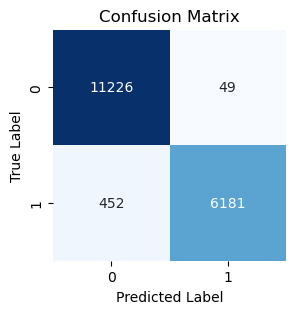

In [197]:
fig, ax = plt.subplots(figsize=(3, 3))
ax = sns.heatmap(conf_mat,
                 annot=True,
                 cmap='Blues',
                 cbar=False,
                 fmt='d')

plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label");

* True Positive (Predicted cancelled and actually cancelled) - 6181
* False Positive (Predicted cancelled and actually not cancelled) - 49
* True Negative (Predicted not cancelled and actually not cancelled) - 11226
* False Negative (Predicted not cancelled and actually cancelled) - 452

In [199]:
hotel_booking['is_canceled'].value_counts()

0    75166
1    44220
Name: is_canceled, dtype: int64

In [196]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     11275
           1       0.99      0.93      0.96      6633

    accuracy                           0.97     17908
   macro avg       0.98      0.96      0.97     17908
weighted avg       0.97      0.97      0.97     17908



* In our dataset we have slightly unbalance classes (Not cancelled - 75116, Cancelled - 44220)
* Therefore we can not use `accuracy` as good measure
* We have to focus on `recall` and `precision`
* In our model `false negatives` are **worse than** `false positives` we should aim for higher `recall`